In [1]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")
import json
# garbage collector
import gc
gc.enable()
from pandas.io.json import json_normalize
import pickle
import pytz
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [2]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',usecols=lambda col: col not in ["hits"],
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop = True,inplace = True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [column+"."+subcolumn for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
#         use_df = df[features]
#         del df
        gc.collect()
        ans = pd.concat([ans,df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans

train = load_df("/home/mediwhale-2/GAC_kaggle/data/train.csv")
test= load_df("/home/mediwhale-2/GAC_kaggle/data/test.csv")


print(train.shape, test.shape)

(903653, 55) (804684, 53)


In [3]:
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype(float)

In [4]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [5]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
trafficSource.adContent
trafficSource.adwordsClickInfo.adNetworkType
trafficSource.adwordsClickInfo.gclId
trafficSource.adwordsClickInfo.page
trafficSource.adwordsClickInfo.slot
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.referralPath
trafficSource.source
trafficSource.adwordsClickInfo.isVideoAd
trafficSource.isTrueDirect


In [14]:
from sklearn.model_selection import GroupKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = test[features]
            y_valid = np.log1p(test["totals.transactionRevenue"])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)

            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            
            val_predictions = model.predict(train[features].iloc[val])
            val_predictions[val_predictions < 0] = 0
            
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(test, predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            
            
            if prepare_stacking:
                train[name].iloc[val] = val_predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                test["prediction_"+str(fold_id)] = model.predict(test[features])
                
        print("Final score: ", full_score)
        return full_score

In [11]:
dev_df = train[train['date']<=20170531]
val_df = train[train['date']>20170531]

dev_df = dev_df.reset_index()
val_df = val_df.reset_index()

In [15]:



Kfolder = KFoldValidation(dev_df,5)



xgbmodel = xgb.XGBRegressor(max_depth=11, learning_rate=0.02, n_estimators=1000, 
                                     objective='reg:linear', gamma=1.45, seed=2019, silent=True,
                                    subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

Kfolder.validate(dev_df, val_df, num_cols + cat_cols, xgbmodel, "xgbpred", prepare_stacking=True)


Fold  0 :
[0]	validation_0-rmse:2.14633
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:2.05275
[200]	validation_0-rmse:1.99347
[300]	validation_0-rmse:1.96815
[400]	validation_0-rmse:1.94878
[500]	validation_0-rmse:1.93842
[600]	validation_0-rmse:1.92986
[700]	validation_0-rmse:1.92362
[800]	validation_0-rmse:1.91632
[900]	validation_0-rmse:1.90871
[999]	validation_0-rmse:1.90419
Fold  0  error:  1.9015681533676916
Fold  0  score:  1.9776106553421067
Fold  1 :
[0]	validation_0-rmse:2.14635
Will train until validation_0-rmse hasn't improved in 50 rounds.
[100]	validation_0-rmse:2.07174
[200]	validation_0-rmse:2.01852
[300]	validation_0-rmse:1.98094
[400]	validation_0-rmse:1.96595
[500]	validation_0-rmse:1.94453
[600]	validation_0-rmse:1.93421
[700]	validation_0-rmse:1.92712
[800]	validation_0-rmse:1.91884
[900]	validation_0-rmse:1.91334
[999]	validation_0-rmse:1.90714
Fold  1  error:  1.904701602623606
Fold  1  score:  1.9818835196859772
Fold  2

1.9870699940007022

In [19]:
Kfolder = KFoldValidation(dev_df,5)



lgbmodel = lgb.LGBMRegressor(n_estimators=1000, objective="regression", metric="rmse", num_leaves=11, min_child_samples=100,
                      learning_rate=0.02, bagging_fraction=0.7, feature_fraction=0.5, bagging_frequency=5, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

Kfolder.validate(dev_df, val_df, num_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.79831
[200]	valid_0's rmse: 1.75341
[300]	valid_0's rmse: 1.74279
[400]	valid_0's rmse: 1.73603
[500]	valid_0's rmse: 1.73263
[600]	valid_0's rmse: 1.72923
[700]	valid_0's rmse: 1.72688
[800]	valid_0's rmse: 1.72491
[900]	valid_0's rmse: 1.72372
[1000]	valid_0's rmse: 1.72229
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.72225
Fold  0  error:  1.7212472196630706
Fold  0  score:  1.7672183456103274
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.80023
[200]	valid_0's rmse: 1.75576
[300]	valid_0's rmse: 1.74593
[400]	valid_0's rmse: 1.73844
[500]	valid_0's rmse: 1.73423
[600]	valid_0's rmse: 1.73083
[700]	valid_0's rmse: 1.72873
[800]	valid_0's rmse: 1.72624
[900]	valid_0's rmse: 1.72504
[1000]	valid_0's rmse: 1.72338
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.72338
Fold  1  error:  1.7223551

1.7699834508170786

findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.
findfont: Font family ['verdana'] not found. Falling back to DejaVu Sans.


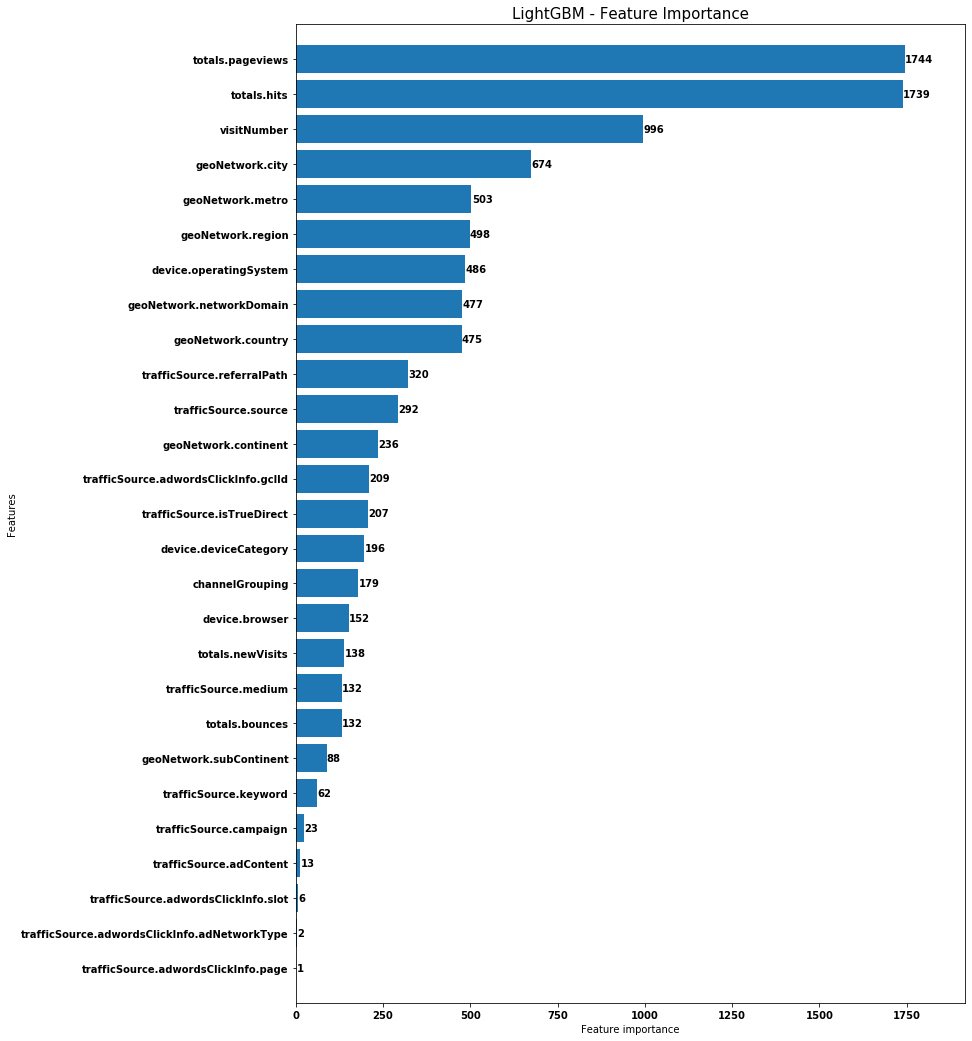

In [21]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(lgbmodel, max_num_features=200, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()


In [24]:
val_df["pred"] = val_df["xgbpred"] * 0.1 + val_df["lgbpred"] * 0.9
score(val_df,val_df["pred"])

1.7837269122815465